In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import calendar

# 1. Load augmented climate + flood data
df = pd.read_csv("Datasets/all_states_climate_2022_with_flood.csv")

# 2. Clean column names
df.columns = df.columns.str.replace('\n', ' ').str.strip()
df = df.rename(columns={
    'Prc. mm/m':  'precip',
    'Tmp. min.': 'tmin',
    'Tmp. max.': 'tmax',
    'Tmp. Mean':'tmean',
    'Rel. Hum. %':'rh',
    'Sun shine':'sun',
    'Wind (2m) m/s':'wind',
    'ETo mm/m':    'eto',
    'State':'state'
})

# 3. Define crop‐specific weights
crop_weights = {
    'maize':   {'precip':0.3, 'tmean':0.2, 'rh':0.1, 'flood':0.4},
    'rice':    {'precip':0.4, 'tmean':0.1, 'rh':0.2, 'flood':0.3},
    'sorghum': {'precip':0.2, 'tmean':0.3, 'rh':0.1, 'flood':0.4},
}

# 4. Normalize variables
vars_to_norm = set().union(*crop_weights.values())
norm = {}
for var in vars_to_norm:
    arr = df[var].astype(float)
    norm[var] = (arr - arr.min()) / (arr.max() - arr.min())
norm_df = pd.DataFrame(norm)
norm_df['state'] = df['state']
norm_df['Month'] = df['Month']

# 5. Compute risk index per crop
for crop, weights in crop_weights.items():
    norm_df[crop] = sum(norm_df[var] * w for var, w in weights.items())

# 6. Aggregate by state & month
state_month = norm_df.groupby(['state','Month'])[[*crop_weights]].mean().reset_index()


parser = argparse.ArgumentParser()
parser.add_argument('--crop',
                    choices=crop_weights.keys(),
                    default='maize',
                    help="Crop to visualize risk for (default: maize)")
parser.add_argument('--state', nargs='*',
                    help="Filter by one or more states (space‐sep)")
parser.add_argument('--month', nargs='*',
                    help="Filter by month abbreviations, e.g. Jan Feb")

# in Jupyter/IPython ignore unknown args
args, _ = parser.parse_known_args()



# apply filters
sel = state_month.copy()
if args.state:
    sel = sel[sel['state'].isin(args.state)]
if args.month:
    sel = sel[sel['Month'].isin(args.month)]

# pivot for heatmap: states vs months
pivot = sel.pivot(index='state', columns='Month', values=args.crop).fillna(0)

# Plot
plt.figure(figsize=(10, max(4, len(pivot)*0.5)))
sns.heatmap(pivot, annot=True, cmap='YlOrRd',
            cbar_kws={'label': f'{args.crop} risk'})
plt.title(f"{args.crop.title()} Risk by State & Month")
plt.ylabel("State")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

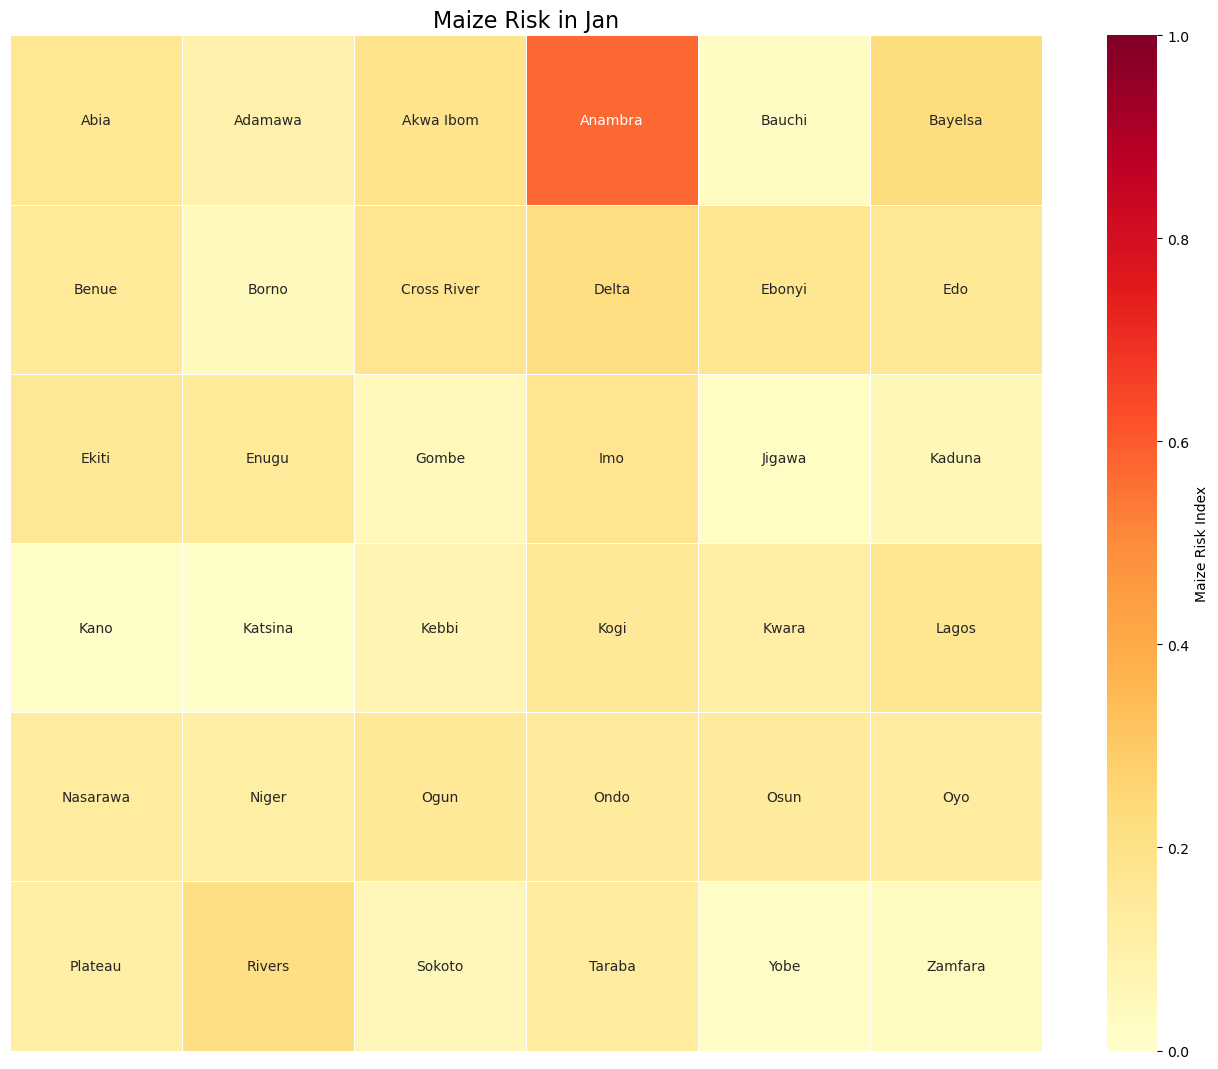

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import math

# Load data
df = pd.read_csv("Datasets/all_states_climate_2022_with_flood.csv")
df.columns = df.columns.str.replace('\n', ' ').str.strip()
df = df.rename(columns={
    'Prc. mm/m':  'precip',
    'Tmp. min.': 'tmin',
    'Tmp. max.': 'tmax',
    'Tmp. Mean':'tmean',
    'Rel. Hum. %':'rh',
    'Sun shine':'sun',
    'Wind (2m) m/s':'wind',
    'ETo mm/m':    'eto',
    'State':'state'
})

# Crop-specific weights
crop_weights = {
    'maize':   {'precip':0.3, 'tmean':0.2, 'rh':0.1, 'flood':0.4},
    'rice':    {'precip':0.4, 'tmean':0.1, 'rh':0.2, 'flood':0.3},
    'sorghum': {'precip':0.2, 'tmean':0.3, 'rh':0.1, 'flood':0.4},
}

# Normalize variables
vars_to_norm = set().union(*crop_weights.values())
norm = {}
for var in vars_to_norm:
    arr = df[var].astype(float)
    norm[var] = (arr - arr.min()) / (arr.max() - arr.min())
norm_df = pd.DataFrame(norm)
norm_df['state'] = df['state']
norm_df['Month'] = df['Month']

# Compute risk index per crop
for crop, weights in crop_weights.items():
    norm_df[crop] = sum(norm_df[var] * w for var, w in weights.items())

# Aggregate
agg = norm_df.groupby(['state','Month'])[[*crop_weights]].mean().reset_index()

# Argparse for filtering
parser = argparse.ArgumentParser()
parser.add_argument('--crop', choices=crop_weights.keys(), default='maize')
parser.add_argument('--month', default='Jan', help="Month abbreviation, e.g. Jan")
args, _ = parser.parse_known_args()

# Filter by month
sel = agg[agg['Month'] == args.month]

# Sort states alphabetically for layout consistency
sel = sel.sort_values('state')
states = sel['state'].values
values = sel[args.crop].values

# Grid layout (adjust columns as needed)
n_cols = 6
n_rows = math.ceil(len(states) / n_cols)

# Pad states and values if not a full grid
pad = n_cols * n_rows - len(states)
states = np.append(states, [''] * pad)
values = np.append(values, [np.nan] * pad)

# Reshape for heatmap
state_grid = np.reshape(states, (n_rows, n_cols))
value_grid = np.reshape(values, (n_rows, n_cols))

# Plot as heatmap
plt.figure(figsize=(n_cols * 2.2, n_rows * 1.8))
ax = sns.heatmap(value_grid, annot=state_grid, fmt='', cmap='YlOrRd', linewidths=0.5, linecolor='white',
                 cbar_kws={'label': f'{args.crop.title()} Risk Index'}, vmin=0, vmax=1)

plt.title(f'{args.crop.title()} Risk in {args.month}', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
